In [59]:
using PyCall
using PyPlot
using Distributions
using LinearAlgebra
using BlockArrays
using DelimitedFiles 
using BenchmarkTools
using LsqFit
include("tripole.jl")


subdif_msd (generic function with 1 method)

# Input parameters used to compute the chain


In [106]:


λ = 0.75 # Square root of the H uang-Rhys factor
hw_vibr = 0.19375*1 #vibrational energy

γ = 0.026 #0.0969*1.2 # HWHM of the lorentzian shape function OR standard deviation of a gaussian dynamic disorder
dz = 3.4 # distance between monomers in the chain in Angstrom
delz = 0.4 # taken from Saikin, accounts for an effective overlap of the wavefunctions
trp_fac= 4.1 # 4.7 tripole interaction multiplicative factor (influences q^2, where q is the tripole charge)
neighbors = 2 # number of neighbors in the chain
θ = 28 #rotation angle in degrees
Mers = 3000 #number of monomers in the chain

Merschain = 1:Mers #iterable object useful for the chain indexing 

D=1 #number of orthogonal degenerate states
n_vib= 2 #how many basis function in the target displaced oscillator you want to approximate, 5 give convergence to actual spectrum

coupling = true
#randomization parameters
σ = hw_vibr*0.6 #static noise  0.08075
σ_conv = hw_vibr*0.58 #convolution for quick estimation of disorder effect, equivalent to no correlation and usable only for small sigma
D_shift = 0.36 # gas-to-crystal shift
hw_00 = 2.681*1.005-D_shift
L0 =  70 #70  correlation length

#choose whether to save or load an existing propagation file 
savefile = true
savepath = string("propagations/En_pos_L0 = 703rd prop2_trapping" )
#match(r^"(L0 )+\d+", savepath)
loadfile = false
# loadpath = string("propagations/En_pos_L0 = 70/En_pos.txt")
loadpath = string("propagations/Pythoncheck/En_pos.txt")
;

 ## Generate the static disorder

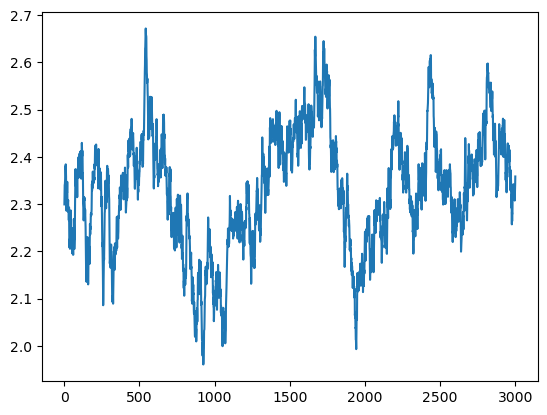

The correlation length is 70

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8c8ba039d0>

In [101]:
μ_E = ones(Mers)*hw_00
if loadfile == false
    if L0==0
        Distro_static = MvNormal(μ_E, σ)

        else
        Pos_M = zeros(Mers, Mers ) # initialize a Mers x Mers matrix that will contain the relative positions btw the monomers

        for i ∈ Merschain
            Pos_M[i, :] = abs.( Merschain .- i) # every monomer is distant 0 monomers with itself 
        end
        Var_M = exp.(-Pos_M/L0)*(σ^2)
        Distro_static = MvNormal(μ_E, Var_M)



    end




    print("The correlation length is " , L0)
    En_pos = rand(Distro_static)

    Var_M = nothing #throw the covariance matrix and the distro in the trash
    Distro_static = nothing 
else
    println("Overriding specifications, loading file")
    En_pos = readdlm(loadpath)[end:-1:1]
end
    

plot(Merschain, En_pos)

In [108]:
#choose whether to save the file to
if savefile == true
    isdir(savepath) || mkdir(savepath) #check if the folder already exists, if not 
    filename = string(savepath, "/En_pos.txt"  )
    writedlm( filename,  En_pos)
end


In [109]:
block_size = D * n_vib #gives the size of the monomer part of the hamiltonian

subblock_size = n_vib # allows you to work with the vibrational states

mat_size = block_size * Mers

mat_div = ones(Int8, Mers)*block_size #divide the matrix in 'Mers' blocks of size 'block_size'
block_div = ones(Int8, D)*subblock_size #divide the block into sub-blocks

Ham_M = BlockArray(zeros(mat_size, mat_size), mat_div, mat_div) #initialize the Hamiltonian

vib_vect = ( 0 : ( n_vib-1) ) .* hw_vibr #vector containing the vibrations
vib_vect =  repeat(vib_vect, D) # repeat the vector if you want to consider degenerate states 



Coupl_M = BlockArray(zeros(block_size, block_size), block_div, block_div) #initialize the coupling matrix
Coupl_Arr = zeros(neighbors, block_size, block_size)

#create the coupling matrix for the m-th neighbor, we make a block matrix
if coupling == true 
    FC_factor = FC_overlap_0K.(Array(0:(n_vib-1)), λ) #calculate the vector of Frank_Condon factors for each n
    FC_M = kron(FC_factor, FC_factor') # calculate the Frank-Condon Matrix
    for m in 1:neighbors
        Coupl_Block_same = trp_fac.*FC_M.*same_int(m*(dz-delz), m, (mod(m*θ+60,120)-60) ) #modulo is for symmetrization after a rotation of 120 degrees
        Coupl_Block_cross = trp_fac.*FC_M.*cross_int(m*(dz-delz), m,  (mod(m*θ+60,120)-60)) #the mod expression keeps θ btw -60 and 60
         
            for i in 1:D
                for j in 1:D
                    if i == j
                        setblock!(Coupl_M, Coupl_Block_same, i, i )
                    else
                        setblock!(Coupl_M, Coupl_Block_cross, i, j )
                    end
                end
            end
        #println(Coupl_M)
        Coupl_Arr[m,:,:] = Coupl_M #create a vector of coupling matrices for each neighbor
        
    end
end

Coupl_Arr[1,:,:]

2×2 Array{Float64,2}:
  0.0623478  -0.0467608
 -0.0467608   0.0350706

In [110]:
#iterate now over the chain to write the complete hamiltonian, we split the cycle in two parts:
#the first up to Mers-neighbors monomers and then for the last monomers since they do not have m neighbors to the right
for i in 1:(Mers-neighbors)
    stat_M = Diagonal(ones(block_size)) .* En_pos[i]  .+ Diagonal(vib_vect) #write the energy of the excited monomers with the vibration present
    setblock!(Ham_M, stat_M, i, i) # set the diagonal blocks of the hamiltonian with the static energies
    
    for m in 1:neighbors
         setblock!(Ham_M, Coupl_Arr[m,:,:], i+m, i) #set the coupling to the m-th neighbor
         setblock!(Ham_M, Coupl_Arr[m,:,:], i, i+m)
    end

end

#here we consider the last monomers of the chain that lack at least one of the right neighbors
for i in (Mers-neighbors+1):Mers 
    stat_M = Diagonal(ones(block_size)) .* En_pos[i]  .+ Diagonal(vib_vect)
    setblock!(Ham_M, stat_M, i, i)
    
    for m in 1:(Mers-i)
         setblock!(Ham_M, Coupl_Arr[m,:,:], i+m, i)
         setblock!(Ham_M, Coupl_Arr[m,:,:], i, i+m)
    end
    
    
    
end


Ham_M = Array(Ham_M);


In [111]:
Ham_M

6000×6000 Array{Float64,2}:
  2.29932      0.0         0.0623478   …   0.0         0.0          0.0
  0.0          2.49307    -0.0467608       0.0         0.0          0.0
  0.0623478   -0.0467608   2.33157         0.0         0.0          0.0
 -0.0467608    0.0350706   0.0             0.0         0.0          0.0
  0.00278719  -0.0020904   0.0623478       0.0         0.0          0.0
 -0.0020904    0.0015678  -0.0467608   …   0.0         0.0          0.0
  0.0          0.0         0.00278719      0.0         0.0          0.0
  0.0          0.0        -0.0020904       0.0         0.0          0.0
  0.0          0.0         0.0             0.0         0.0          0.0
  0.0          0.0         0.0             0.0         0.0          0.0
  0.0          0.0         0.0         …   0.0         0.0          0.0
  0.0          0.0         0.0             0.0         0.0          0.0
  0.0          0.0         0.0             0.0         0.0          0.0
  ⋮                                 

In [112]:
#find the eigenvectors and eigenenergies of the matrix

eig_En = @btime eigvals(Ham_M)
eig_V = @btime eigvecs(Ham_M) ;



  31.853 s (14 allocations: 276.81 MiB)
  76.684 s (17 allocations: 826.13 MiB)


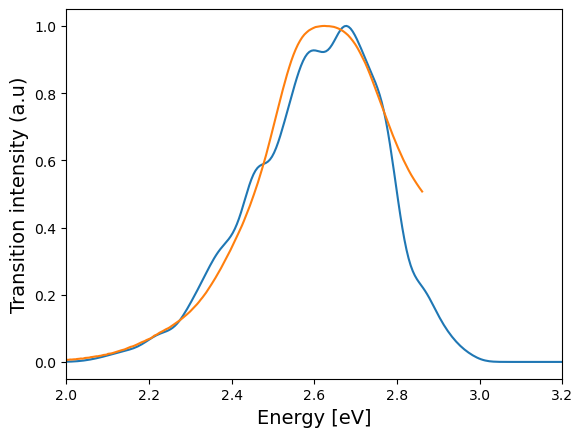

27.372123153923624

In [113]:
Peak_intens = (eig_V' * repeat(FC_factor, Mers*D)).^2  #calculate the intensity of each peak according to the Frank-Condon principle


x_size = 1000
x_intens = LinRange(0,5, x_size)
envelope = zeros(x_size)
IPR = zeros(mat_size) #calculate the inverse participation ratio

for i in 1:mat_size
    
    envelope = envelope + gaussian.(x_intens, eig_En[i], γ )*Peak_intens[i]
    
    IPR[i] = 1/(sum( eig_V[:,i].^(4) ))
    
end

L_D = mean(IPR)# evaluate the mean delocalization length
print(L_D)

envelope = envelope/maximum(envelope)

if coupling == false
    exp_data = readdlm("spectral_data/AbsTHF.dat", skipstart = 1)
    exp_label = "Experimental monomer data in THF"
    nothing
else
    exp_data = readdlm("spectral_data/AbsDod.dat", skipstart = 1)
    exp_label = "Experimental polymer data in "
    nothing
end

A = exp_data[:,2]
B = exp_data[:,1]
E= (c.*ħ./(B.*10^(-9)))./eV 
A = A./E

A =  A ./ maximum(A)

#load the experimental data

plot(x_intens, envelope, label = "OPA Holstein model")
plot(E, A, label = exp_label)
ylabel("Transition intensity (a.u)")
xlabel("Energy [eV]")
xlim(left = 2.0, right=3.2)
rc("axes", labelsize=14) 


# Propagation of the excitation

We start now considering a packet of excitons propagating along the fiber line

In [129]:
kbT = 0.026 #thermal energy in eV
wc = 0.1 #cutoff freq for ohmic bath
Dt = 100000 # timestep measured in hbar/eV, about 0.6 femtoseconds 
Wo = 1 #coupling to bath constant

startpos = 1500  #starting position
sigmastart = 340/2.355/0.34 #broadening of the gaussian at the beginning
diff_lim = 206/2.355/0.34 #PSF taken from optical FWHM = sigma*2.355 = 206nm, transformed in the position basis
x_pos = (Merschain.-Mers/2).*(dz*10^(-4)) #calculate the position along the axis
;

In [130]:
Ediff_M = zeros(mat_size, mat_size) #matrix of the energy differences
Dens_M = abs.(eig_V).^2 #computes the exciton probability density of the chain for each eigenstate
Overlap_M =  Dens_M' * Dens_M #this computes the overlap of the exciton densities of the eigenstates

for i in 1:mat_size
   Ediff_M[:, i] = eig_En .- eig_En[i]  
end

Wscatt_M = Bose_weight.(Ediff_M, kbT) .* (OhmSD.(Ediff_M, wc).*0.109423) .* Overlap_M

sum_scatt = sum(Wscatt_M, dims=1) #sum over all scattering rates
sum_scatt = dropdims(sum_scatt, dims=1) #necessary for algorithmic stability, sum preserves the dimesion of the array in Julia

Renorm_M = - Diagonal(sum_scatt) + Wscatt_M;

In [131]:
Mark_M = @btime exp(Dt * Renorm_M);

  96.162 s (51 allocations: 6.17 GiB)


In [132]:
#create the excitation via a gaussian shaped illumination

pstart_n = gaussian.(1:Mers, startpos, sigmastart)
pstart_n = repeat(pstart_n, inner = (D*n_vib) )
pstart_n = pstart_n/sum(pstart_n)

#morph now to energy space

pstart_e = Dens_M' * pstart_n

#now delete the eigenstates that cannot be excited by a laser of energy 2.7589 ± 0.006 eV
unexcitable_En = findall(x-> (x <= (2.7589-0.006) || x >= (2.7589+0.006)), eig_En)
pstart_e[unexcitable_En] .= 0
pstart_e = pstart_e/sum(pstart_e);



In [133]:
PowerMark_M = Mark_M ^ (Wo * 1) ;

In [134]:
p_e = pstart_e
p_n = pstart_n
first_meanpos = 0


iterations = 100
parr_e = zeros(mat_size, iterations)
parr_n = zeros(Mers, iterations)
coarse_arr = zeros(Mers, iterations)

time_vec = LinRange(1 : iterations)*Dt*6.582*(10^(-7) ) #convert to nanoseconds in the timescale
MSD_vec = zeros(iterations)

for i in 1:iterations
    p_e = PowerMark_M * p_e
    p_n = Dens_M * p_e
    
    psingle_n = p_n[2:2:6000] .+ p_n[1:2:6000] #add together the occupancies in the first and second vibrational states
    
    coarse_n = zeros(Mers)
    for m in Merschain
    
        coarse_n = coarse_n + gaussian.(Merschain, m, diff_lim*0.69 )*psingle_n[m] #convolve probabilities with a gaussian
    
    end
    
    
    
    coarse_n = coarse_n/sum(coarse_n)  #normalize the distribution
    #even if you shine the laser on in the center of the fiber, the initial exciton population is determined
    #by the projection of the eigenstates on the position basis, this does not guarantee that your startpos
    #coincides with the position of the actual first excitation, calculate the mean position of the population
    #after the first measurement you can perform (which is what is done experimentally) to correct for that.
    if i == 1
        first_meanpos = sum(coarse_n .*(Merschain))
        print( (first_meanpos-Mers/2)*dz*10^(-4))
    end
    
    MSD_eff =sum(coarse_n.*((Merschain .- first_meanpos).^2) .* (dz*10^(-4) )  )   #calculate the msd 
    coarse_n = coarse_n/maximum(coarse_n) #set maximum to 1 to compare with experiments
    
    MSD_vec[i] = MSD_eff
    parr_e[:, i] = p_e 
    parr_n[:, i] = psingle_n
    coarse_arr[:, i] = coarse_n
    
end
;

0.020631761576034156

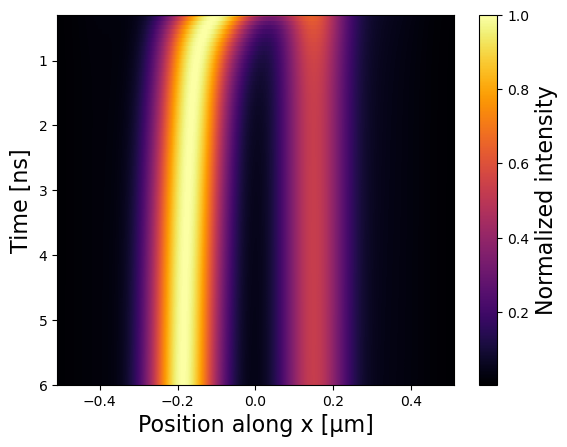

In [135]:


pcolor(x_pos, time_vec,   coarse_arr' , cmap = "inferno")
ylim(6,0.3)
xlabel("Position along x [μm]", size = 16)
ylabel("Time [ns]", size = 16)
colorbar().set_label("Normalized intensity", size = 16)
savefig(string("$savepath", "/tres-propagation.png"), dpi=300)

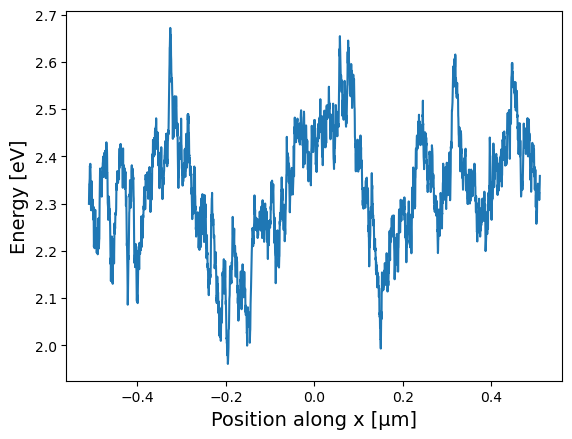

In [136]:
plot(x_pos, En_pos)
xlabel("Position along x [μm]", size = 14)
ylabel("Energy [eV]", size = 14)
savefig(string("$savepath", "/landscape.png"), dpi=300)

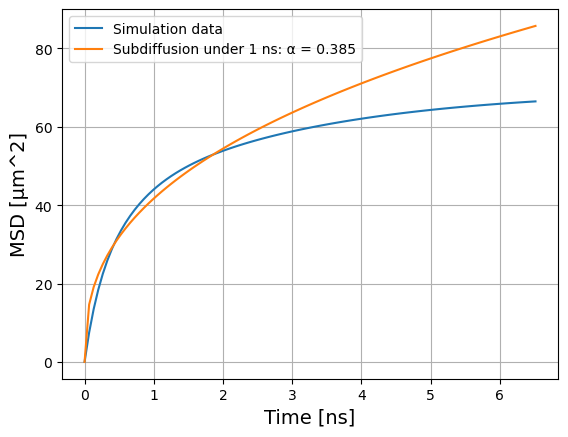

The subdiffusion coefficient is: 0.3846826474931892

In [137]:
norm_time = (time_vec[1:end].-time_vec[1])
norm_MSD = (MSD_vec[1:end].-MSD_vec[1])


@. model(x, p) = subdif_msd(x, p[1], p[2])

fit = curve_fit(model, norm_time[1:40], norm_MSD[1:40], [0.5,0.5])
coeffs = coef(fit) 

plot(norm_time,  norm_MSD, label = "Simulation data")
plot(norm_time[1:end],  subdif_msd.(norm_time[1:end], coeffs[1], coeffs[2]), label = string("Subdiffusion under 1 ns: α = ", round(coeffs[1]; digits = 3) ) )
print("The subdiffusion coefficient is: ", coeffs[1])
xlabel("Time [ns]", size = 14)
ylabel("MSD [μm^2]", size = 14)
grid()
legend()
savefig(string("$savepath", "/MSD.png"), dpi=300)

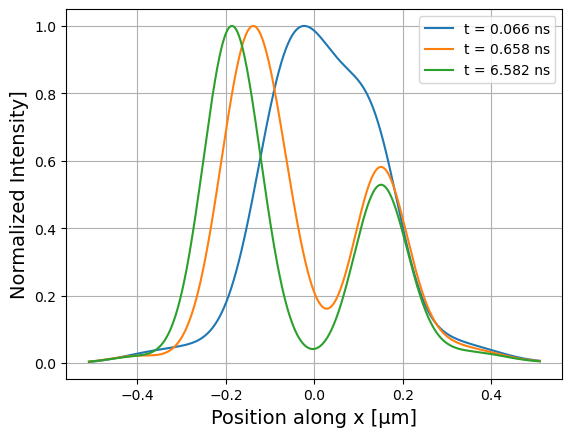

In [138]:
for i in [1, 10, 100]
    plot(x_pos, coarse_arr[:,i], label = string("t = " , round(time_vec[i]; digits=3) , " ns") )   
end
 
xlabel("Position along x [μm]", size = 14)
ylabel("Normalized Intensity]", size = 14)
grid()
legend()
savefig(string("$savepath", "/discr-propagation.png"), dpi=300)

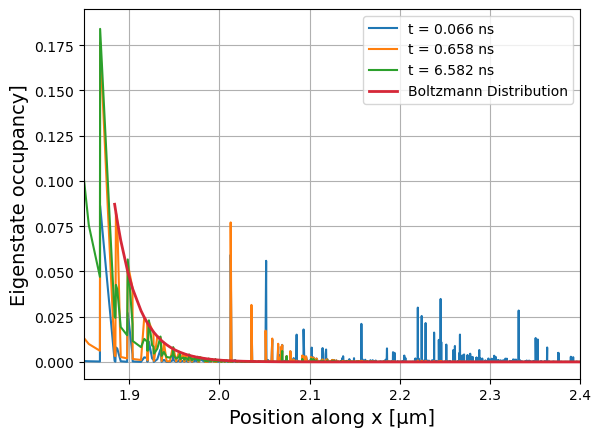

In [139]:
for i in [1, 10, 100]
    plot(eig_En, parr_e[:,i], label = string("t = " , round(time_vec[i]; digits=3) , " ns") )   
end
Z = sum(Boltz_weight.(eig_En[5:end], kbT))
plot(eig_En[5:end], Boltz_weight.(eig_En[5:end], kbT)/Z, label="Boltzmann Distribution", linewidth = 2, color = "#d62738")

xlim([1.85,2.4])
xlabel("Position along x [μm]", size = 14)
ylabel("Eigenstate occupancy]", size = 14)
grid()
legend()
savefig(string("$savepath", "/en-propagation.png"), dpi=300)